# 成交量指标策略
*市场短期是投票机，长期是称重机*

## 目录
1. 什么是成交量？
2. 如何计算成交量指标？
3. 如何用图形展示成交量？
4. 如何用成交量指标来编写策略？

## 什么是成交量？

成交量有三种可能，分别是量增、量减、量平。 

价格也有三种可能，分别是上涨、下跌、横盘。

量价理论表明价涨量增是上涨趋势的确认，反之价跌量增是下跌趋势的确认。

## 如何计算成交量指标？
---
### 1. ADV-平均成交量
$MA(volume,20)$

---

### 2. OBV
OBV属于市场的领先指标，计算方法是如果当天价格高于前一天的价格，当天成交量就用加的，反之就用减的来计算出OBV指标，这样有助于分析成交量与价格的关系。

---

### 3. A/D
A/D 指标在OBV的基础上对价格的波幅进行了计算，真实波幅越大，指标中的成交量占比越大。

$\frac{A}{D}=\frac{Close-Open}{High-Low}*Volume$

---

### 4. WVAP
按成交量来衡量价格的权重，成交量越大价格权重越大。

$sum(close * volume, 20)/sum(volume, 20)$

## 如何用图形展示成交量？

In [27]:
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import talib as ta
warnings.filterwarnings('ignore')
# data = pd.Panel({s: pd.read_excel('threesymbol.xlsx', sheetname=s, index_col='datetime') 
#                    for s in ['BTCUSDT.binance', 'EOSUSDT.binance', 'ETHUSDT.binance']})
data = pd.read_excel('threesymbol.xlsx', sheetname='BTCUSDT.binance', index_col='datetime')

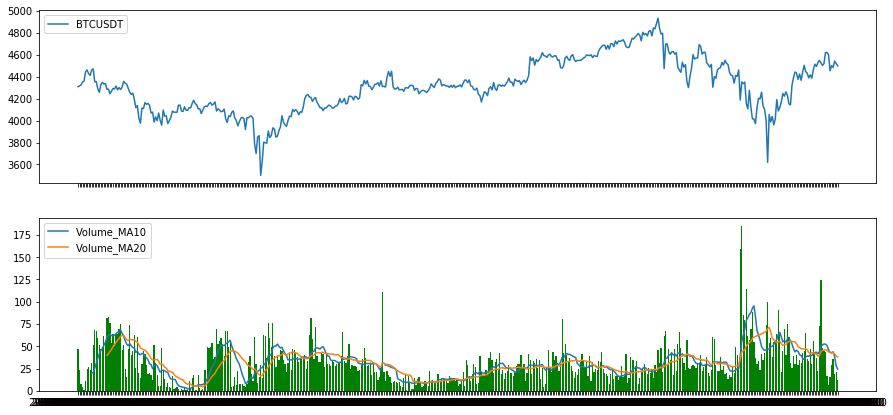

In [11]:
adv10 = ta.MA(data.volume.values, 10)
adv20 = ta.MA(data.volume.values, 20)
data['close']=data.close
volume=data['volume']=data.volume

fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,7))
ax.plot(data['close'], label='BTCUSDT')
ax.legend(loc='upper left')
ax1.bar(volume.index, data['volume'],color='g')
ax1.plot(adv10, label='Volume_MA10')
ax1.plot(adv20, label='Volume_MA20')
plt.legend(loc='upper left')
plt.show()

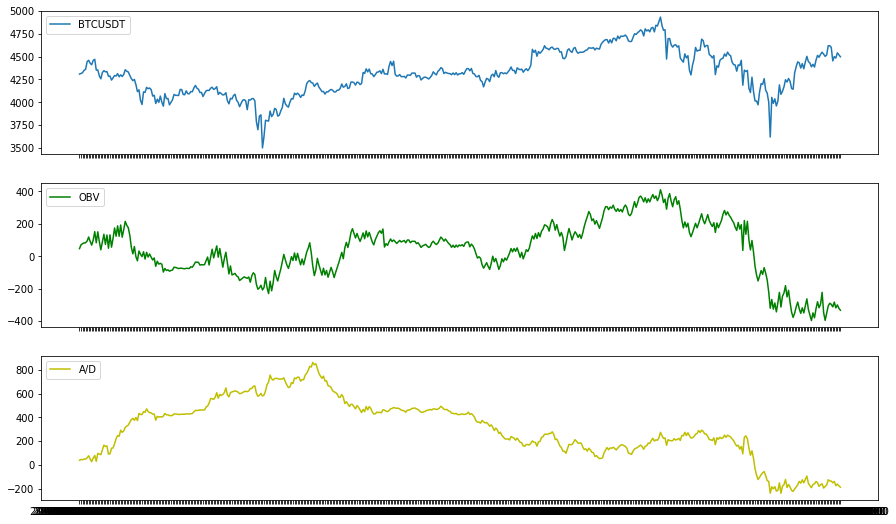

In [28]:
#OBV & A/D
Close = data.close.values
Volume = data.volume.values
High = data.high.values
Low= data.low.values
data['close']=data.close

OBV = pd.Series(ta.OBV(Close, Volume), index=data.index)
AD = pd.Series(ta.AD(High, Low, Close, Volume), index=data.index)

fig, (ax, ax1,ax2) = plt.subplots(3, 1, sharex=True, figsize=(15,9))
ax.plot(data['close'], label='BTCUSDT')
ax.legend(loc='upper left')
ax1.plot(OBV,'g', label='OBV')
ax1.legend(loc='upper left')
ax2.plot(AD, 'y', label='A/D')
ax2.legend(loc='upper left')
plt.show()

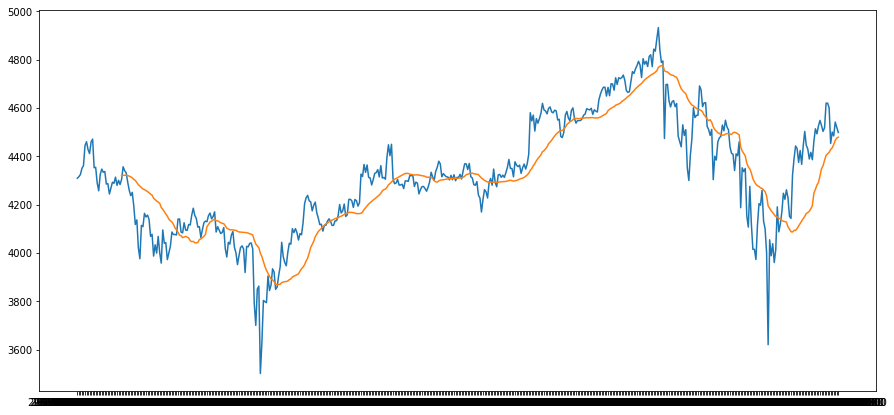

In [30]:
#vwap
VWAP=ta.SUM(data.close.values*data.volume.values) / ta.SUM(data.volume.values)
data['close']=data.close
plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.plot(VWAP)
plt.show()

## 如何用成交量指标来编写策略？
### VWAP策略
买入：

close>VWAP

卖出：

close<VWAP


In [ ]:
#VWAP
    # 策略参数
    VWAPPeriod = 70
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    VWAPsignal = {}  
    transactionPrice = {}
    #设置变量
    self.setArrayManagerSize(self.VWAPPeriod * 4)
    self.VWAPsignal = {s: 0 for s in self.symbolList}
    self.transactionPrice = {s: 0 for s in self.symbolList}


        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)):
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)):
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])



        #信号计算
        VWAP = ta.SUM(am3.close*am3.volume, self.VWAPPeriod) / ta.SUM(am3.volume, self.VWAPPeriod)

        if bar.close > VWAP[-1]:
            self.VWAPsignal[symbol] = -1
        elif bar.close < VWAP[-1]:
            self.VWAPsignal[symbol] = 1
        else:
            self.VWAPsignal[symbol] = 0

        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            if self.VWAPsignal[symbol] == 1:
                self.buy(symbol, bar.close * 1.02, self.lots)
            if self.VWAPsignal[symbol] == -1:
                self.short(symbol, bar.close * 0.98, self.lots)
                
    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

## 作业
参考以上代码用其他成交量指标做策略